In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train') 

# Because of some issue with test set I am using test set

README.md:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

In [3]:
dataset2 = load_dataset("Bingsu/Human_Action_Recognition", split='train')
dataset2

Dataset({
    features: ['image', 'labels'],
    num_rows: 12600
})

In [4]:
dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 12600
})

In [5]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

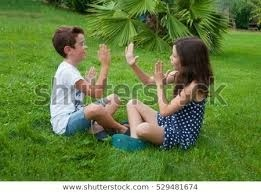

In [7]:
dataset['train'][0]['image']

In [8]:
set(dataset['train']['labels'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [9]:
labels = dataset['train'].features['labels'].names
labels

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [10]:
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [11]:
print(label2id)
print(id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


## Image preprocessing

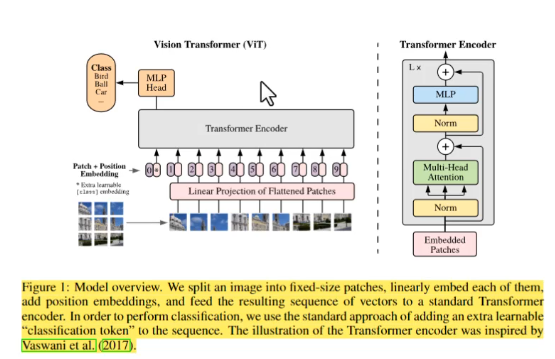

In [12]:
from transformers import AutoImageProcessor #--> it kind of tokenizer

model_ckpt = 'google/vit-base-patch16-224-in21k'
# model_ckpt = 'microsoft/swinv2-tiny-patch4-window16-256'

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [13]:
model_ckpt

'google/vit-base-patch16-224-in21k'

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [15]:
size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size
       else (image_processor.size['height'], image_processor.size['width']))

size

(224, 224)

In [16]:
image_processor.size

{'height': 224, 'width': 224}

In [17]:
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [18]:
def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]
    
    del batch['image']
    
    return batch

In [19]:
transforms

<function __main__.transforms(batch)>

In [20]:
dataset = dataset.with_transform(transforms)

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

## Evaluate the model

In [22]:
!pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


## Vision Transformer (ViT) Fine Tuning for Image Classification

In [23]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

In [24]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [25]:
model = AutoModelForImageClassification.from_pretrained(
model_ckpt,
num_labels = len(labels),
id2label = id2label,
label2id = label2id
).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

In [26]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="Train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [27]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.588743,0.717460
2,1.862900,1.225294,0.744048
3,1.862900,1.103376,0.754365
4,1.158400,1.031637,0.756746
5,0.980700,1.016053,0.755952


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=1575, training_loss=1.315966293092758, metrics={'train_runtime': 1269.2158, 'train_samples_per_second': 39.71, 'train_steps_per_second': 1.241, 'total_flos': 3.906051336688435e+18, 'train_loss': 1.315966293092758, 'epoch': 5.0})

In [28]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.0479122400283813,
 'eval_accuracy': 0.7507936507936508,
 'eval_runtime': 22.1896,
 'eval_samples_per_second': 113.567,
 'eval_steps_per_second': 3.56,
 'epoch': 5.0}

In [29]:
trainer.save_model('vit-human-pose-classification')

## Ziping the file and download the zip

In [30]:
import shutil

shutil.make_archive('zipped_directory', 'zip', '/kaggle/working/vit-human-pose-classification')

'/kaggle/working/zipped_directory.zip'

In [33]:
from IPython.display import FileLink

FileLink('zipped_directory.zip')

/kaggle/working/zipped_directory.zip

## Classification Report and Confusion Matrics

In [36]:
reading = 'https://i.pinimg.com/736x/b5/9a/71/b59a71b35439acf14adb58f592959a03.jpg'
calling = 'https://img.freepik.com/free-photo/cheerful-young-woman-poses-torn-yellow-paper-hole-wall-emotional-expressive-shouting-calling-with-speaker_155003-39643.jpg'
dancing = 'https://i.pinimg.com/236x/98/6f/23/986f233c57672f9062671f45aafc4f9f.jpg'
hugging = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSPHfOnjLdmicDkAIFe-XYkfVERTbFBeMSfA&s'
laughing = 'https://img.freepik.com/premium-photo/professional-photo-handsome-man-laughing-pose-with-expressive-face-body-language_732449-15695.jpg'

emotions = [reading, calling, dancing, hugging, laughing]

In [37]:
emotions

['https://i.pinimg.com/736x/b5/9a/71/b59a71b35439acf14adb58f592959a03.jpg',
 'https://img.freepik.com/free-photo/cheerful-young-woman-poses-torn-yellow-paper-hole-wall-emotional-expressive-shouting-calling-with-speaker_155003-39643.jpg',
 'https://i.pinimg.com/236x/98/6f/23/986f233c57672f9062671f45aafc4f9f.jpg',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSPHfOnjLdmicDkAIFe-XYkfVERTbFBeMSfA&s',
 'https://img.freepik.com/premium-photo/professional-photo-handsome-man-laughing-pose-with-expressive-face-body-language_732449-15695.jpg']

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
logits = trainer.predict(dataset['test'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [43]:
logits = logits.predictions

In [44]:
y_pred = np.argmax(logits, axis=1)
y_pred

array([ 4,  8, 12, ..., 12, 11,  8])

In [45]:
y_true=[x['labels'] for x in dataset['test']]

In [51]:
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.58      0.61      0.59       153
          clapping       0.77      0.76      0.77       165
           cycling       0.92      0.89      0.91       160
           dancing       0.81      0.86      0.83       177
          drinking       0.82      0.73      0.77       164
            eating       0.89      0.79      0.84       180
          fighting       0.86      0.83      0.84       183
           hugging       0.72      0.79      0.75       153
          laughing       0.73      0.77      0.75       177
listening_to_music       0.63      0.66      0.64       149
           running       0.79      0.88      0.83       170
           sitting       0.67      0.63      0.65       178
          sleeping       0.79      0.86      0.82       161
           texting       0.65      0.56      0.60       157
      using_laptop       0.75      0.71      0.73       193

          accuracy                    

Text(95.58159722222221, 0.5, 'Actual')

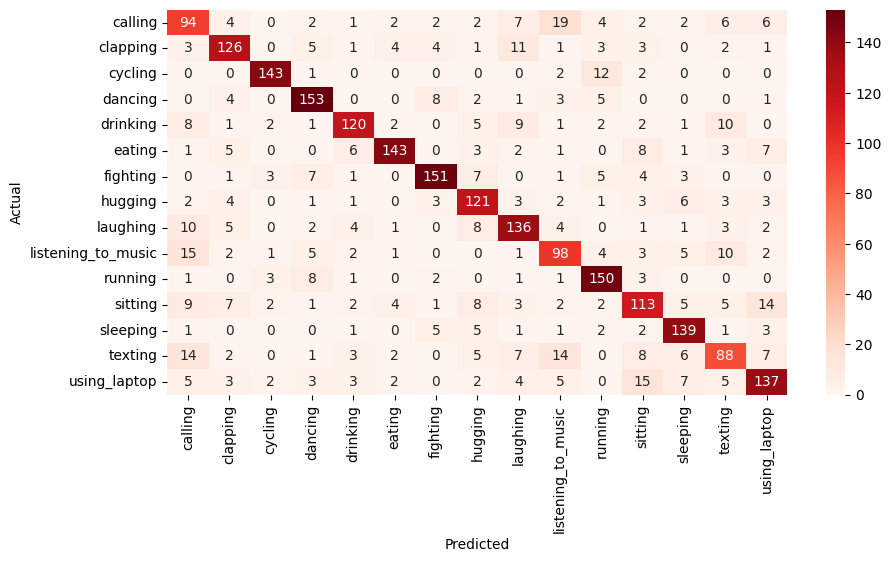

In [63]:
cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d',cbar=True, cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
